In [1]:
import matplotlib.pyplot as plt
import numpy as np
import re
import matplotlib
%matplotlib notebook
import pandas as pd

import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset'] = False


import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def density_scatter(x, y, bins=50, xlim=None, ylim=None, filename=None):
    fig = plt.figure(figsize=(10, 10))
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    plt.clf()
    plt.imshow(heatmap.T, extent=extent, origin='lower')
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    if filename is not None:
        plt.savefig(filename)
    plt.show()
    
import matplotlib.animation as animation

In [171]:
rays_y = np.loadtxt("./output/test/rays_0.00.dat")

<IPython.core.display.Javascript object>


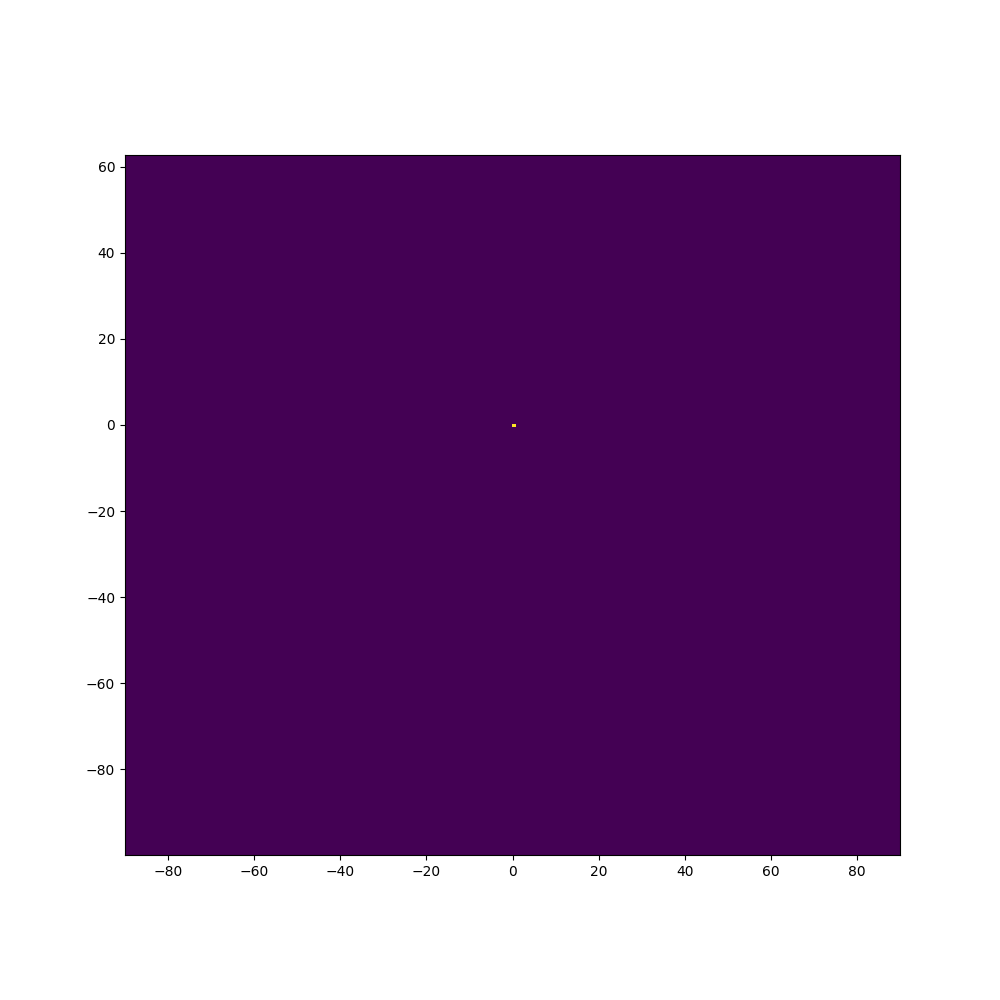

In [172]:
m = np.logical_and(np.abs(rays_y[:,0]) <= 100, np.abs(rays_y[:,1]) <= 100)
x = rays_y[:,0][m]
y = rays_y[:,1][m]
density_scatter(x, y, bins=[200, 200])

In [166]:
m = np.logical_and(np.abs(rays_y[:,0]) <= 20, np.abs(rays_y[:,1]) <= 20)
x = rays_y[:,0][m]
y = rays_y[:,1][m]
density_scatter(x, y, bins=[200, 200])

m = np.logical_and(np.abs(rays_y[:,0]) <= 15, np.abs(rays_y[:,1]) <= 15)
x = rays_y[:,0][m]
y = rays_y[:,1][m]
density_scatter(x, y, bins=[200, 200])

m = np.logical_and(np.abs(rays_y[:,0]) <= 30, np.abs(rays_y[:,1]) <= 30)
x = rays_y[:,0][m]
y = rays_y[:,1][m]
density_scatter(x, y, bins=[500, 500])

OSError: ./output/test/rays_y_0.00.dat not found.

In [58]:
def get_image_data(filename, gamma=0.6, debug=False, hide_max=False, logscale=False):
    
    extent = None
    image_size = None
    with open(filename, 'r') as f:
        header0 = f.readline().strip()
        header1 = f.readline().strip()
        header2 = f.readline().strip()

        _s = re.split('\(|\,|\)', header0)
        _x = re.split('\(|\,|\)', header1)
        _y = re.split('\(|\,|\)', header2)
        image_size = [int(_s[1]),int(_s[2])]
        extent = [float(_x[1]),float(_x[2]),float(_y[1]),float(_y[2])]
    image = np.loadtxt(filename).reshape(image_size)
    if (debug):
        _all = image.shape[0] * image.shape[1]
        _z = image[image == 0].shape[0]
        print(f"{filename}")
        print(f"\tzeros: {_z} ({100 * _z/_all}%)")
        print(f"\tmean & std: {np.mean(image)} +- {np.std(image)}")
        print(f"\ttotal_rays: {np.sum(image)}")
    
    img = np.zeros_like(image)
    if gamma is not None:
        img[image > 0] = image[image > 0]**gamma
    if logscale is not None and logscale:
        img[image > 0] = np.log10(image[image > 0])
    if img[img == np.max(img)].shape[0] < 5 and hide_max:
        img[img == np.max(img)] = np.mean(img) # removing center-of-mass pixel with extreame amplification
    return img, extent

output/test/image_0.00.dat
	zeros: 504964 (50.4964%)
	mean & std: 50.264787 +- 52.34491456526251
	total_rays: 50264787.0
output/test/image_0.00.dat
	zeros: 504964 (50.4964%)
	mean & std: 50.264787 +- 52.34491456526251
	total_rays: 50264787.0


<IPython.core.display.Javascript object>


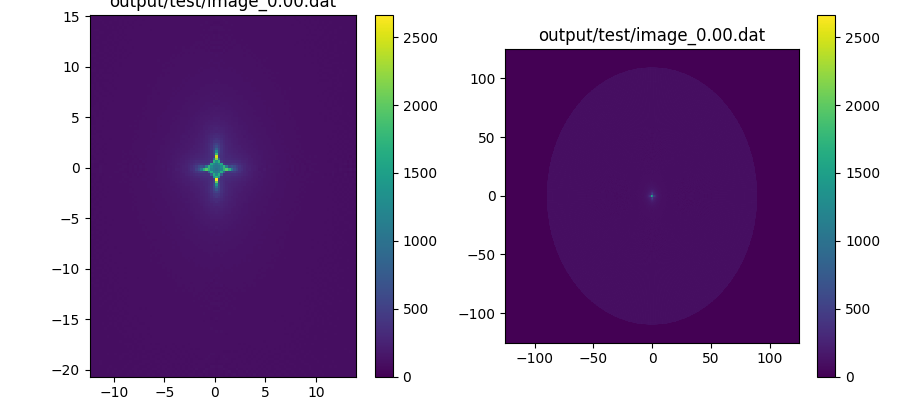

In [38]:
filename1 = "output/test/image_0.00.dat"
filename2 = "output/test/image_0.00.dat"

img1, extent1 = get_image_data(filename1, gamma=1, debug=True)
img2, extent2 = get_image_data(filename2, gamma=1, debug=True)

fig, (ax1, ax2) = plt.subplots(figsize=(9,4), ncols=2)
pos1 = ax1.imshow(img1, interpolation='none', extent=extent1, origin='lower')
pos2 = ax2.imshow(img2, interpolation='none', extent=extent2, origin='lower')
ax1.set_title(filename1)
ax2.set_title(filename2)
fig.colorbar(pos1, ax=ax1)
fig.colorbar(pos2, ax=ax2)
fig.tight_layout()
plt.show()

output/test/image_0.00.dat
	zeros: 0 (0.0%)
	mean & std: 51.262191 +- 46.58351479739929
output/test/image_0.00.dat
	zeros: 0 (0.0%)
	mean & std: 51.262191 +- 46.58351479739929


<IPython.core.display.Javascript object>


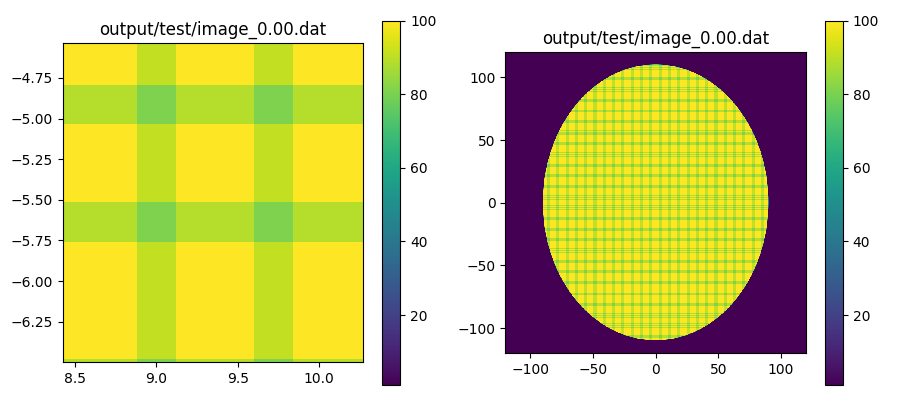

In [11]:
filename1 = "output/test/image_0.00.dat"
filename2 = "output/test/image_0.00.dat"

img1, extent1 = get_image_data(filename1, gamma=1, debug=True)
img2, extent2 = get_image_data(filename2, gamma=1, debug=True)

fig, (ax1, ax2) = plt.subplots(figsize=(9,4), ncols=2)
pos1 = ax1.imshow(img1, interpolation='none', extent=extent1, origin='lower')
pos2 = ax2.imshow(img2, interpolation='none', extent=extent2, origin='lower')
ax1.set_title(filename1)
ax2.set_title(filename2)
fig.colorbar(pos1, ax=ax1)
fig.colorbar(pos2, ax=ax2)
fig.tight_layout()
plt.show()

In [127]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

<IPython.core.display.Javascript object>


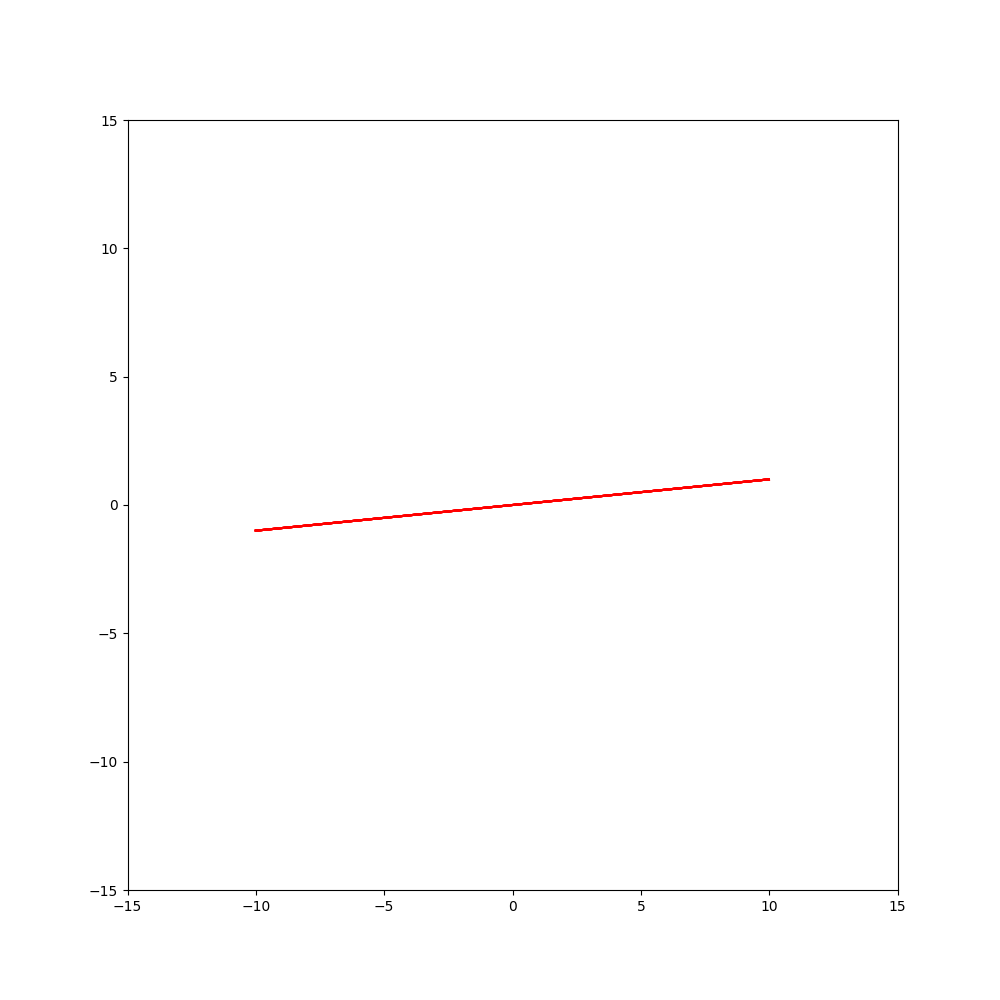

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9


In [130]:
fig, ax = plt.subplots(figsize=(10,10))

ims = []

for i in np.arange(0, 1, 0.1):
    filename1 = "output/reference/image_%.2f.dat" % i
    filename2 = "output/reference/lc_%.2f.dat" % i
    img, extent = get_image_data(filename1, logscale=1)
    lc = get_lc_data(filename2)    
    title = plt.text(0.5,1.01, "t=%.2f" % i, ha="center",va="bottom", transform=ax.transAxes, fontsize="large")
    text = ax.text('','','')
    im = ax.imshow(img, extent=extent, origin='lower', interpolation='bicubic')
    ax.plot(lc['y1'], lc['y2'], color='red')
    ims.append([text, im, title])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=False, repeat=True, repeat_delay=1000)
ani.save("images/reference_moving_stars.mp4")
plt.show()

<IPython.core.display.Javascript object>


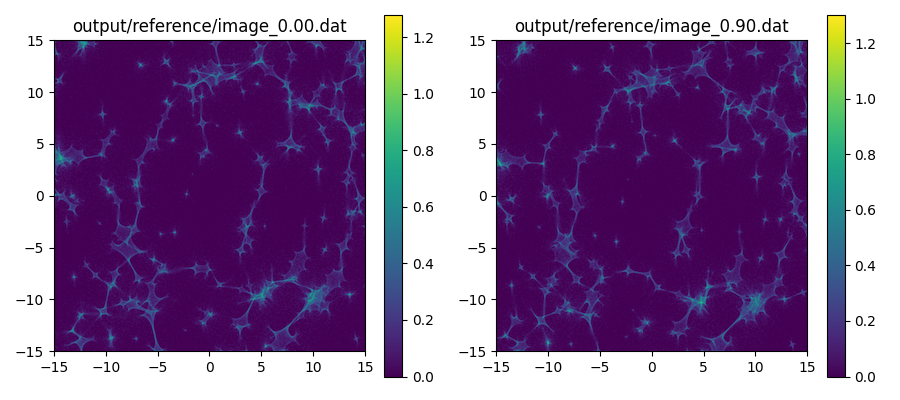

In [63]:
filename1 = "output/reference/image_0.00.dat"
filename2 = "output/reference/image_0.90.dat"

img1, extent1 = get_image_data(filename1, logscale=1)
img2, extent2 = get_image_data(filename2, logscale=1)

fig, (ax1, ax2) = plt.subplots(figsize=(9,4), ncols=2)
pos1 = ax1.imshow(img1, interpolation='bessel', extent=extent1, origin='lower')
pos2 = ax2.imshow(img2, interpolation='bessel', extent=extent2, origin='lower')
ax1.set_title(filename1)
ax2.set_title(filename2)
fig.colorbar(pos1, ax=ax1)
fig.colorbar(pos2, ax=ax2)
fig.tight_layout()
plt.show()

In [39]:
import pandas as pd

In [102]:
def get_lc_data(filename):
    data = np.loadtxt(filename)
    return pd.DataFrame(data=data.copy(), columns=["y1", "y2", "norm", "ampl"])

In [50]:
!pwd

/local/projects/science/microlensing


output/reference/image_0.00.dat
	zeros: 500668 (50.0668%)
	mean & std: 0.664888 +- 0.8913977492993798
	total_rays: 664888.0


<IPython.core.display.Javascript object>


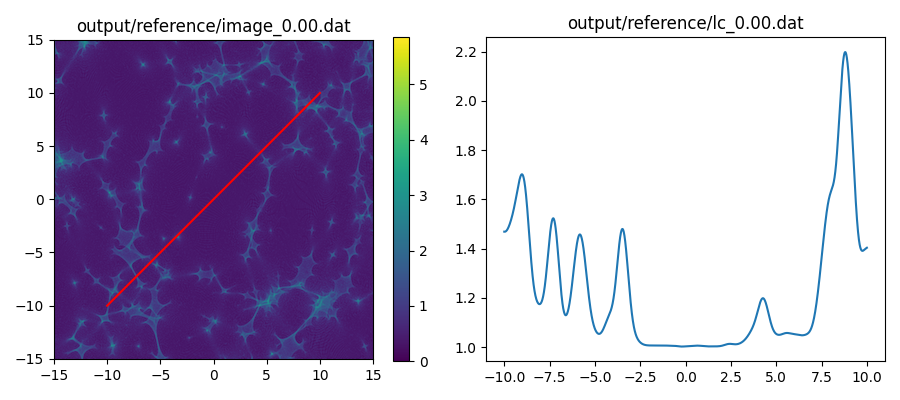

In [70]:
filename1 = "output/reference/image_0.00.dat"
filename2 = "output/reference/lc_0.00.dat"

img1, extent1 = get_image_data(filename1, gamma=0.6, debug=True)
lc = get_lc_data(filename2)

fig, (ax1, ax2) = plt.subplots(figsize=(9,4), ncols=2)
pos1 = ax1.imshow(img1, interpolation='bessel', extent=extent1, origin='lower')
ax1.plot(lc['y1'], lc['y2'], color='red')
pos2 = ax2.plot(lc['y1'], lc['ampl']/lc['norm'], '-')
#pos2 = ax2.plot(lc['y1'], lc['norm'], '-')
#pos2 = ax2.plot(lc['y1'], lc['ampl'], '-')
ax1.set_title(filename1)
ax2.set_title(filename2)
fig.colorbar(pos1, ax=ax1)
fig.tight_layout()
plt.show()

output/reference/image_0.00.dat
	zeros: 500668 (50.0668%)
	mean & std: 0.664888 +- 0.8913977492993798
	total_rays: 664888.0


<IPython.core.display.Javascript object>


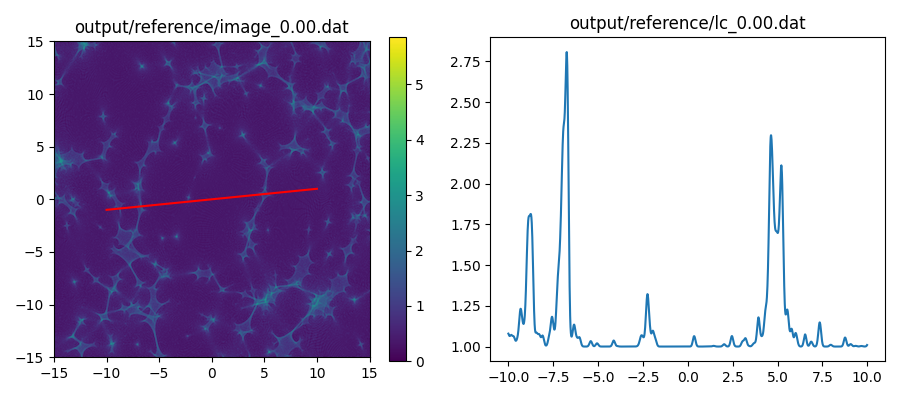

In [112]:
filename1 = "output/reference/image_0.00.dat"
filename2 = "output/reference/lc_0.00.dat"

img1, extent1 = get_image_data(filename1, gamma=0.6, debug=True)
lc = get_lc_data(filename2)

fig, (ax1, ax2) = plt.subplots(figsize=(9,4), ncols=2)
pos1 = ax1.imshow(img1, interpolation='bessel', extent=extent1, origin='lower')
ax1.plot(lc['y1'], lc['y2'], color='red')
pos2 = ax2.plot(lc['y1'], lc['ampl']/lc['norm'], '-')
#pos2 = ax2.plot(lc['y1'], lc['norm'], '-')
#pos2 = ax2.plot(lc['y1'], lc['ampl'], '-')
ax1.set_title(filename1)
ax2.set_title(filename2)
fig.colorbar(pos1, ax=ax1)
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


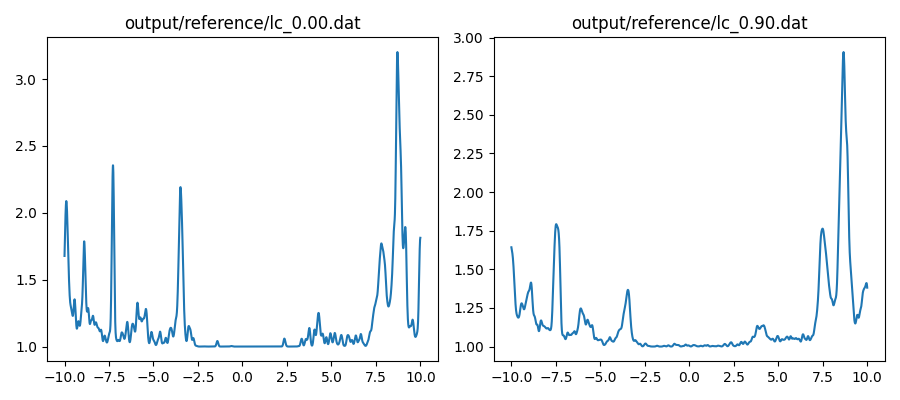

In [88]:
filename1 = "output/reference/lc_0.00.dat"
filename2 = "output/reference/lc_0.90.dat"

lc1 = get_lc_data(filename1)
lc2 = get_lc_data(filename2)

fig, (ax1, ax2) = plt.subplots(figsize=(9,4), ncols=2)
pos1 = ax1.plot(lc1['y1'], lc1['ampl']/lc1['norm'], '-')
pos2 = ax2.plot(lc2['y1'], lc2['ampl']/lc2['norm'], '-')
ax1.set_title(filename1)
ax2.set_title(filename2)
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


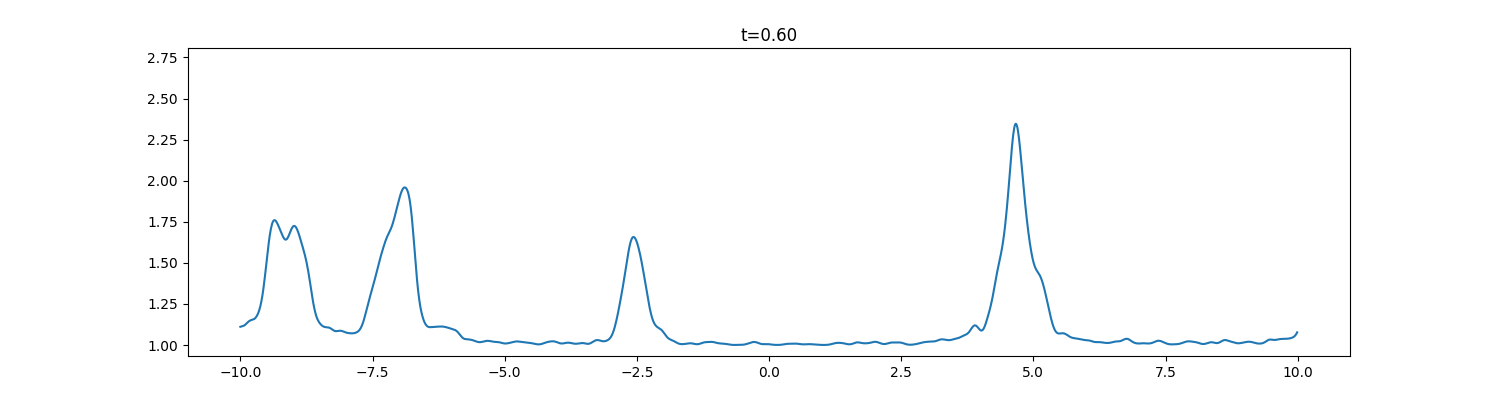

In [122]:
fig, ax = plt.subplots(figsize=(15,4))

ims = []

for i in np.arange(0, 1, 0.1):
    filename = "output/reference/lc_%.2f.dat" % i
    lc = get_lc_data(filename)
    ims.append(lc.copy())


title = plt.text(0.5,1.01, "t=%.2f" % 0, ha="center",va="bottom", transform=ax.transAxes, fontsize="large")
line1, = ax.plot(ims[9]['y1'], ims[9]['ampl']/ims[9]['norm'], '-')
ax.set_ylim([None, np.max([np.max(lc['ampl']/lc['norm']) for lc in ims])])

def init():
    line1.set_ydata(lc['ampl']/lc['norm'])
    return [line1]

def animate(i):
    title.set_text("t=%.2f" % (i * 0.1))
    line1.set_ydata(ims[i]['ampl']/ims[i]['norm'])
    return [line1]

ani = animation.FuncAnimation(fig, animate, init_func=init, 
                              blit=True, frames=10, repeat=True,
                              interval=200, repeat_delay=1000)
ani.save('result.mp4')